In [ ]:
%matplotlib inline
import numpy as np
import lib.io.stan
import lib.syn_data
import matplotlib.pyplot as plt
import os

In [ ]:
results_dir = 'results/exp9'
os.makedirs(results_dir,exist_ok=True)
os.makedirs(f'{results_dir}/logs',exist_ok=True)
os.makedirs(f'{results_dir}/figures',exist_ok=True)

SC = np.loadtxt('data/CJ/connectivity/weights.txt')
SC = SC / np.max(SC)
SC[np.diag_indices(SC.shape[0])] = 0
gain_mat = np.loadtxt('data/CJ/gain_inv-square.txt')

In [ ]:
nn = SC.shape[0]
ns = gain_mat.shape[0]
nt = 10000
I1 = 3.1
tau0 = 200.0
k = 2.0
epsilon = 0.001
amplitude = 1.0
offset = 0
time_step = 0.1

stan_fname = 'vep-snsrfit'
lib.io.stan.create_process(['bash','/home/anirudhnihalani/scripts/stancompile.sh', stan_fname],block=True)

syn_data = np.load(f'{results_dir}/syn_tvb_ez=6-34_pz=22-13-9-27.npz')
for sigma in np.arange(0.1,2.1,0.1):
    data = {'nn':nn, 'ns':ns, 'nt':nt, 'I1':I1, 'tau0':tau0, 'SC':SC, 'gain': gain_mat,
            'sigma':sigma, 'k':k, 'epsilon': epsilon, 'amplitude': amplitude,
            'offset': offset, 'time_step':time_step, 'seeg':syn_data['seeg'].T}
    
    input_Rfile_name = f'fit_data_sigma{sigma}.R'
    lib.io.stan.rdump(f'{results_dir}/{input_Rfile_name}',data)

    nchains = 4
    with open('vep-snsrfit.sh','r') as fd:
        slurm_script = fd.read().format(results_dir, nchains, input_Rfile_name, sigma)
    with open(f'tmp/vep-snsrfit-sigma{sigma:0.1f}.sh','w') as fd:
        fd.write(slurm_script)
    lib.io.stan.create_process(['sbatch',f'tmp/vep-snsrfit-sigma{sigma:0.1f}.sh'],block=False)


In [3]:
import lib.io.stan
# import importlib
# importlib.reload(lib.io.stan)

csv_fname = 'results/exp9/samples_sigma0.1_chain4.csv'
nwarmup = 500
nsampling = 500
ignore_warmup = True
variables_of_interest = ['lp__','accept_stat__','stepsize__','treedepth__','n_leapfrog__','divergent__','energy__','x0']
pstr_samples_1 = lib.io.stan.read_samples(csv_fname,nwarmup,nsampling,ignore_warmup,variables_of_interest) # read sampler diagnostics and x0 for all sampling iterations

# csv_fname = 'results/exp9/samples_sigma0.1_chain4.csv'
# nwarmup = 500
# nsampling = 10
# ignore_warmup = True
# variables_of_interest = ['x','z']
# pstr_samples_2 = lib.io.stan.read_samples(csv_fname,nwarmup,nsampling,ignore_warmup,variables_of_interest) # read 10 samples of hidden state variables x and z

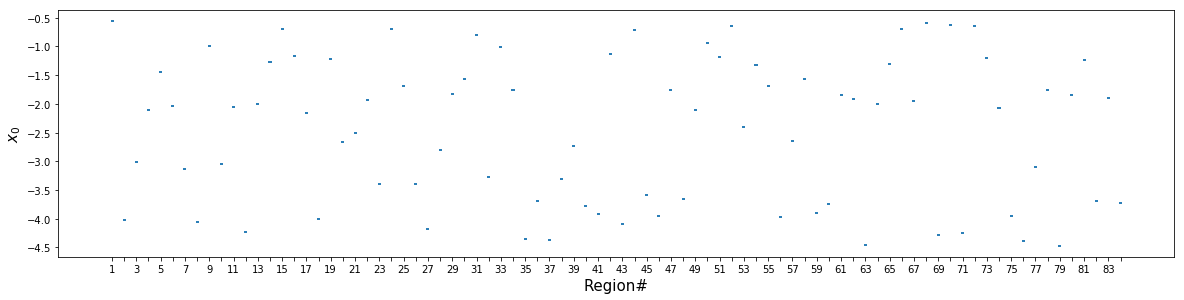

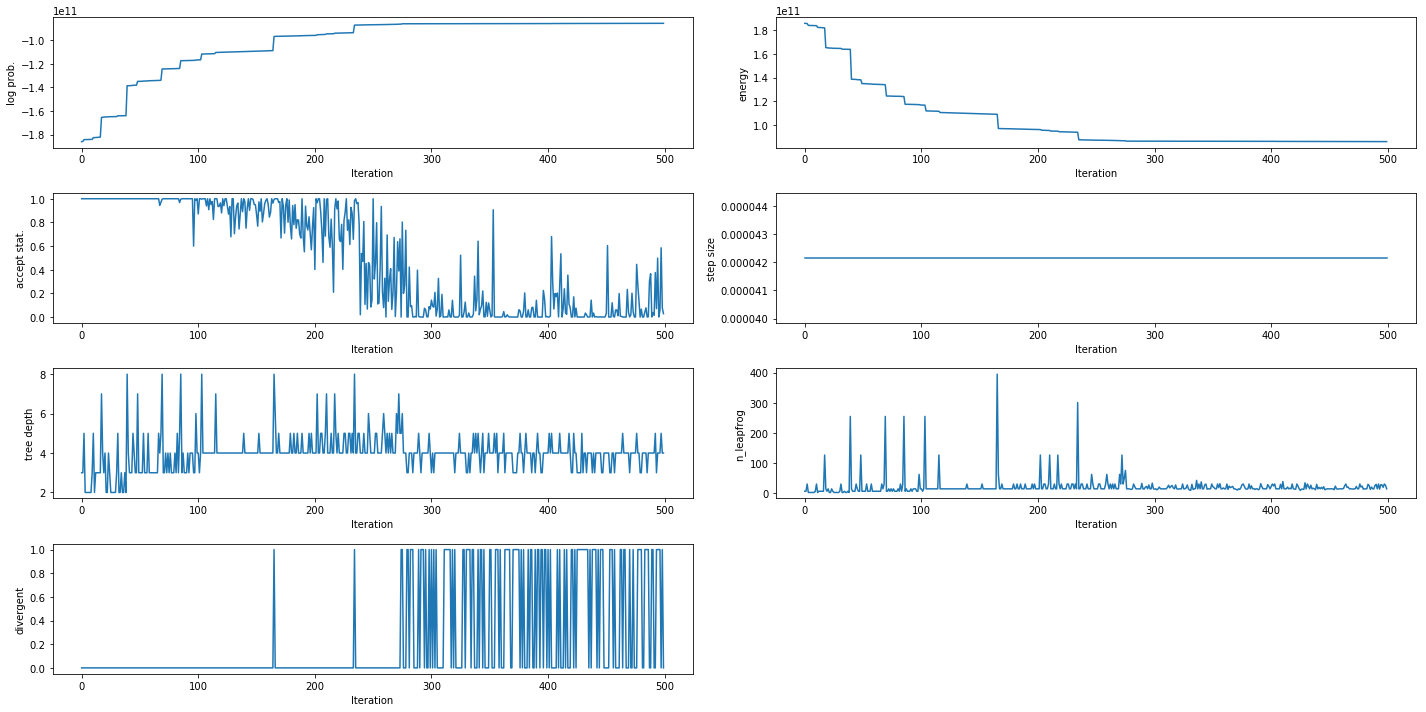

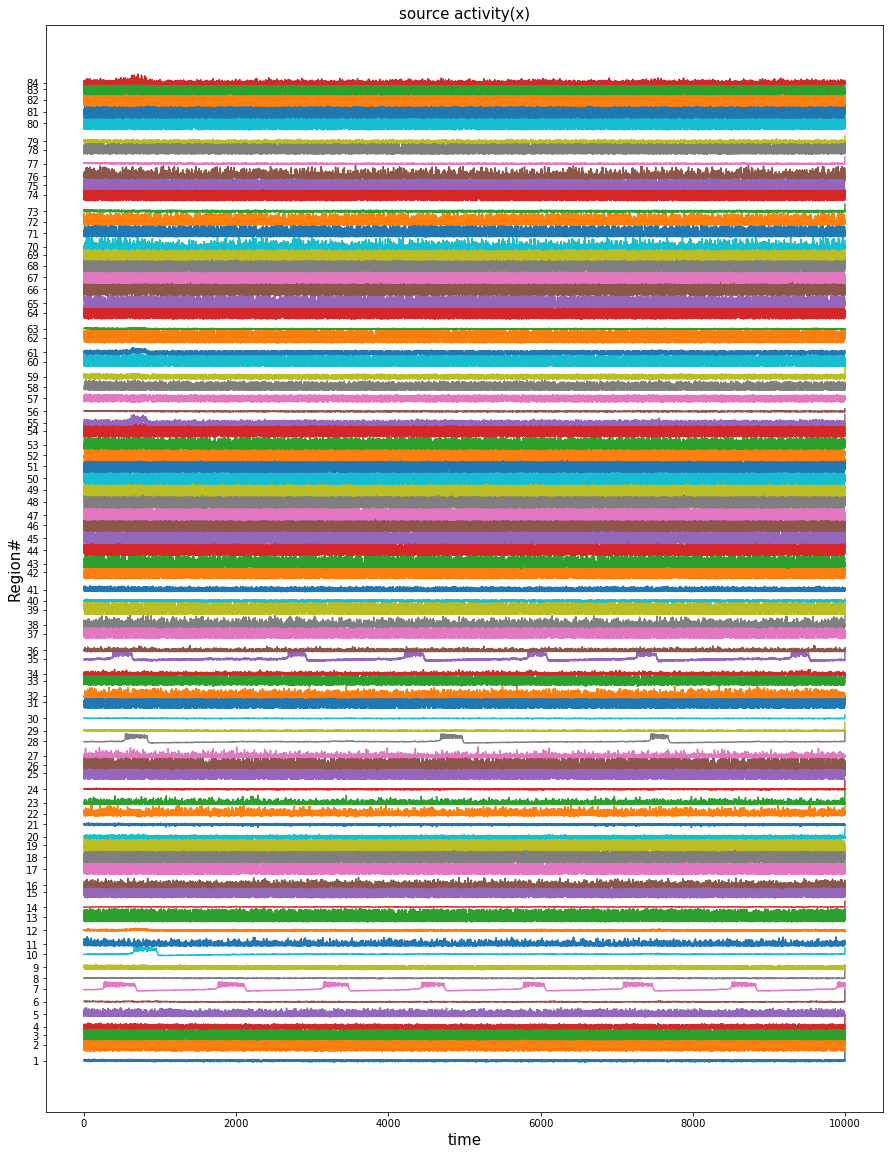

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20,10))
plt.subplot(211)
plt.violinplot(pstr_samples_1['x0'][:,:]);
xtick_labels = []
for i in range(84):
    if(i%2 == 0):
        xtick_labels.append(str(i+1))
    else:
        xtick_labels.append('')
plt.xticks(np.r_[1:85],xtick_labels);
plt.xlabel('Region#',fontsize=15);
plt.ylabel('$x_0$',fontsize=15);

# Plot the HMC convergence diagnostics
plt.figure(figsize=(20,10))
plt.subplot(4,2,1)
plt.plot(pstr_samples_1['lp__'])
plt.xlabel('Iteration')
plt.ylabel('log prob.')

plt.subplot(4,2,2)
plt.plot(pstr_samples_1['energy__'])
plt.xlabel('Iteration')
plt.ylabel('energy')

plt.subplot(4,2,3)
plt.plot(pstr_samples_1['accept_stat__'])
plt.xlabel('Iteration')
plt.ylabel('accept stat.')

plt.subplot(4,2,4)
plt.plot(pstr_samples_1['stepsize__'])
plt.xlabel('Iteration')
plt.ylabel('step size')

plt.subplot(4,2,5)
plt.plot(pstr_samples_1['treedepth__'])
plt.xlabel('Iteration')
plt.ylabel('tree depth')

plt.subplot(4,2,6)
plt.plot(pstr_samples_1['n_leapfrog__'])
plt.xlabel('Iteration')
plt.ylabel('n_leapfrog')

plt.subplot(4,2,7)
plt.plot(pstr_samples_1['divergent__'])
plt.xlabel('Iteration')
plt.ylabel('divergent')

plt.tight_layout();

# Mean and 2*std of source activity(x) estimated from posterior samples
plt.figure(figsize=(15,20))
x_mean = np.mean(pstr_samples_2['x'], axis = 0)
x_std = np.std(pstr_samples_2['x'], axis = 0)
nt = x_mean.shape[0]
nn = x_mean.shape[1]
for i in range(nn):
    plt.plot(x_mean[:,i]+4*i)
    plt.fill_between(np.r_[0:nt], x_mean[:,i] - 2*x_std[:,i] + 4*i, x_mean[:,i] + 2*x_std[:,i] + 4*i,alpha=0.1)
plt.title('source activity(x)',fontsize=15);
plt.xlabel('time',fontsize=15);
plt.ylabel('Region#',fontsize=15);
plt.yticks(np.mean(x_mean,axis=0) + 4*np.r_[0:nn], np.r_[1:nn+1]);